# QQQ prices prediction

We are going to predict the price of QQQ using the following methods:
1. LSTM
2. Facebook Prophet
3. ARIMA

## Libraries


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

Using device:  cpu


## Data opening and basic functions

In [154]:
def open_data(print_head=False, print_shape=False):
    df = pd.read_csv('Data/QQQ_full.csv', header=0, parse_dates=True)
    del df['Unnamed: 0']
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)
    df.set_index('Date', inplace=True)
    df['Volume'] = df['Volume'].str.replace(',', '')
    df['Volume'] = df['Volume'].astype(float)
    df = df.dropna()

    #now get rid of the features that the RFC deemed not important for classification
    df = df.drop(columns=['Inflation','3-month','5-year','2-year'])
    if print_shape:
        print(df.shape)
    if print_head:
        print(df.head())
    return df

def plot_data(df, columns = ['Close']):
    plt.figure(figsize=(16, 8))
    for i, col in enumerate(columns):
        plt.subplot(len(columns), 1, i+1)
        plt.plot(df[col], label=col)
        plt.title(col, y=0.5, loc='right')
    plt.show()

(1195, 14)
              Open    High     Low   Close      Volume 1-month 6-month 1-year  \
Date                                                                            
2019-01-02  150.99  155.75  150.88  154.88  58576672.0    2.40    2.51   2.60   
2019-01-03  152.60  153.26  149.49  149.82  74820234.0    2.42    2.47   2.50   
2019-01-04  152.18  157.00  151.74  156.23  74709320.0    2.40    2.51   2.57   
2019-01-07  156.54  158.86  156.11  158.09  52059328.0    2.42    2.54   2.58   
2019-01-08  159.56  160.11  157.20  159.52  49388688.0    2.40    2.54   2.60   

           3-year 7-year 10-year 20-year 30-year        VIX  
Date                                                         
2019-01-02   2.47   2.56    2.66    2.83    2.97  23.219999  
2019-01-03   2.35   2.44    2.56    2.75    2.92  25.450001  
2019-01-04   2.47   2.56    2.67    2.83    2.98  21.379999  
2019-01-07   2.51   2.60    2.70    2.86    2.99  21.400000  
2019-01-08   2.57   2.63    2.73    2.88    3.00 

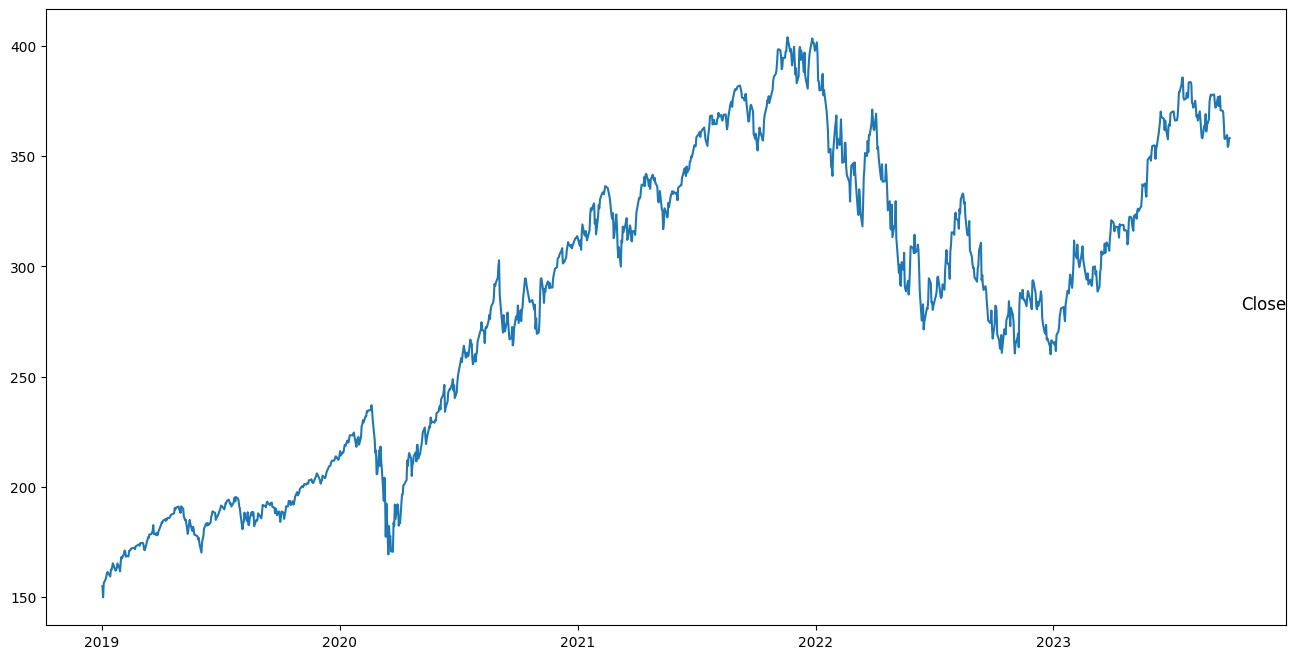

In [155]:
df = open_data(print_head=True, print_shape=True)
plot_data(df)

## Data exploration
We plan to use the predicting closing price of QQQ as the next day's opening price. 
We want to check if there is a huge difference between the closing price and the opening price.

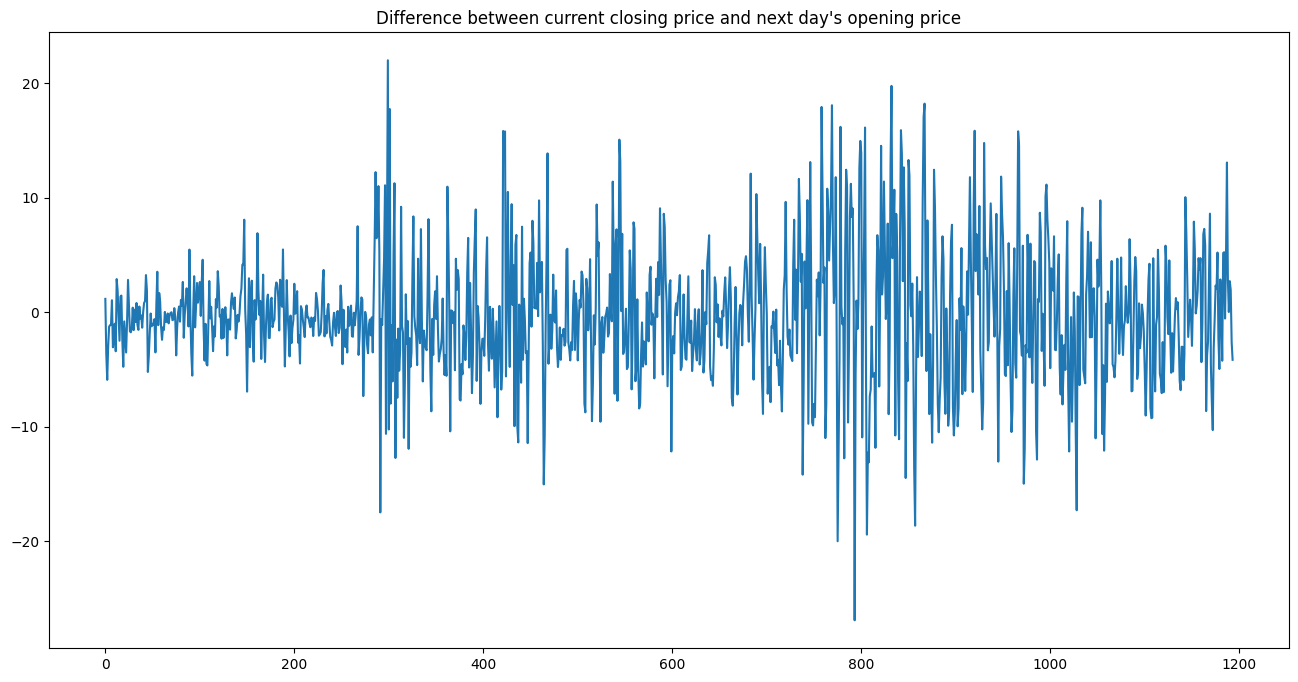

In [144]:
# Plot the difference between the current closing price and next day's opening price

diff = df['Open'] - df['Close'].shift(-1)
plt.figure(figsize=(16, 8))
plt.plot(diff)
plt.title('Difference between current closing price and next day\'s opening price')
plt.show()

As we see from the plot, the difference between the closing price and the opening price is quite huge, and has a high variance. 
Therefore, we are gonna use the it for a day to day strategy, and we will consider that we have access to the current day's opening price.

# Prediction with LSTM

## Data preparation

In [156]:
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
df = df[~df.eq('ND').any(axis=1)]
y = df['High']
X = df.drop('High', axis=1)

# We are going to predict the next high of day price using the previous 60 day high prices
y = y[X.index]

In [157]:
X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

class StockDataset(Dataset):
    def __init__(self, X, y, device=device, window=60):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
        self.y = self.y.view(-1, 1)
        self.len = len(X) - window
        self.window = window
    
    def __getitem__(self, index):
        start = index
        end = index + self.window
        return self.X[start:end], self.y[end-1]
    
    def __len__(self):
        return self.len
    
train_set = StockDataset(X_train, y_train)
test_set = StockDataset(X_test, y_test)

In [159]:
print("Train set size: ", len(train_set))
# orint the first 5 samples
for i in range(5):
    print(train_set[i])

Train set size:  889
(tensor([[-1.0000e+00, -9.8902e-01, -9.6018e-01, -4.6467e-01, -2.0266e-01,
         -1.0912e-01, -6.0550e-02, -1.0438e-02,  1.6166e-02,  4.6455e-02,
         -3.2099e-02,  5.8824e-02, -6.7168e-01],
        [-9.8735e-01, -1.0000e+00, -1.0000e+00, -2.9578e-01, -1.9601e-01,
         -1.2343e-01, -9.7248e-02, -6.0543e-02, -3.9261e-02, -2.4450e-03,
         -7.1605e-02,  3.2086e-02, -6.0900e-01],
        [-9.9065e-01, -9.8222e-01, -9.4956e-01, -2.9694e-01, -2.0266e-01,
         -1.0912e-01, -7.1560e-02, -1.0438e-02,  1.6166e-02,  5.1345e-02,
         -3.2099e-02,  6.4171e-02, -7.2340e-01],
        [-9.5640e-01, -9.4769e-01, -9.3493e-01, -5.3243e-01, -1.9601e-01,
         -9.8390e-02, -6.7890e-02,  6.2630e-03,  3.4642e-02,  6.6015e-02,
         -1.7284e-02,  6.9519e-02, -7.2284e-01],
        [-9.3267e-01, -9.3907e-01, -9.2367e-01, -5.6020e-01, -2.0266e-01,
         -9.8390e-02, -6.0550e-02,  3.1315e-02,  4.8499e-02,  8.0685e-02,
         -7.4074e-03,  7.4866e-02, -7.4898

## Model definition

In [160]:
# Define the LSTM model

class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # add 2 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear2(self.linear(lstm_out.view(len(seq),-1)))
        return pred[-1]
    
# Define a 2nd bigger LSTM model with 2 LSTM layers and 3 fully-connected layers

class LSTMnetwork2(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add 2 LSTM layers:
        self.lstm1 = nn.LSTM(input_size,hidden_size)
        self.lstm2 = nn.LSTM(hidden_size,hidden_size)
        
        # add 3 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out1, self.hidden = self.lstm1(
            seq.view(len(seq),1,-1), self.hidden)
        lstm_out2, self.hidden = self.lstm2(
            lstm_out1.view(len(seq),1,-1), self.hidden)
        pred = self.linear3(self.linear2(self.linear(lstm_out2.view(len(seq),-1))))
        return pred[-1]
    
# Define a 3rd bigger LSTM model with 2 LSTM layers, 3 fully-connected layers and dropout, RELU activation function and l1 regularization

class LSTMnetwork3(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add 3 LSTM layers:
        self.lstm1 = nn.LSTM(input_size,hidden_size)
        self.lstm2 = nn.LSTM(hidden_size,hidden_size)
        
        # add 3 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,output_size)

        # add dropout layer:
        self.dropout = nn.Dropout(0.2)

        # add RELU activation function:
        self.relu = nn.ReLU()
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out1, self.hidden = self.lstm1(
            seq.view(len(seq),1,-1), self.hidden)
        lstm_out2, self.hidden = self.lstm2(
            lstm_out1.view(len(seq),1,-1), self.hidden)
        pred = self.linear3(self.dropout(self.relu(self.linear2(self.relu(self.linear(lstm_out2.view(len(seq),-1)))))))
        return pred[-1]

## Model training

In [161]:
input_size = len(X_train[0])
model = LSTMnetwork2(input_size=input_size).to(device)
criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

model

LSTMnetwork2(
  (lstm1): LSTM(13, 100)
  (lstm2): LSTM(100, 100)
  (linear): Linear(in_features=100, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=1, bias=True)
)

Epoch 0 Loss: 0.022778339684009552
Test loss: 0.13660931587219238
Epoch 1 Loss: 0.030342239886522293
Test loss: 0.14215707778930664
Epoch 2 Loss: 0.002052396535873413
Test loss: 0.03329747915267944
Epoch 3 Loss: 0.011893868446350098
Test loss: 0.13939905166625977
Epoch 4 Loss: 0.025159567594528198
Test loss: 0.08744198083877563
Epoch 5 Loss: 0.01160544902086258
Test loss: 0.051112592220306396
Epoch 6 Loss: 0.002967149019241333
Test loss: 0.10319417715072632
Epoch 7 Loss: 0.012283265590667725
Test loss: 0.0484771728515625
Epoch 8 Loss: 0.009180352091789246
Test loss: 0.0730714201927185
Epoch 9 Loss: 0.003242000937461853
Test loss: 0.05478322505950928
Epoch 10 Loss: 0.008774913847446442
Test loss: 0.031070709228515625
Epoch 11 Loss: 0.020318180322647095
Test loss: 0.05747115612030029
Epoch 12 Loss: 0.002087533473968506
Test loss: 0.1736547350883484
Epoch 13 Loss: 0.011823661625385284
Test loss: 0.04314470291137695
Epoch 14 Loss: 0.010830923914909363
Test loss: 0.10687750577926636
Epoch 1

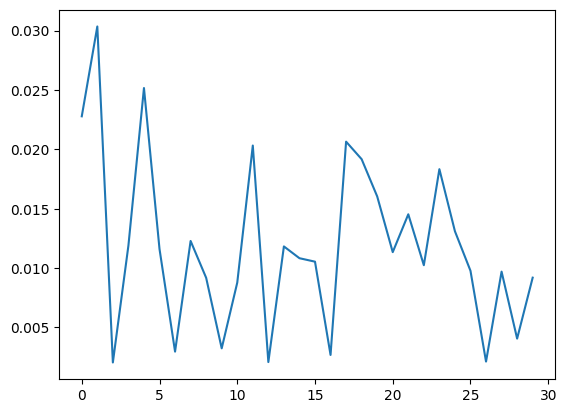

In [181]:
epochs = 30

losses = []

best_model = None
best_loss = 1000000

for i in range(epochs):
    for seq, y_train in train_set:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {i} Loss: {loss.item()}')

    for seq, y_train in test_set:
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        with torch.no_grad():
            y_test_pred = model(seq)
            test_loss = criterion(y_test_pred, y_train)
    print(f'Test loss: {test_loss.item()}')
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model

plt.plot(range(epochs), losses)
plt.show()

## Model evaluation and saving

We are now going to evaluate the model and save it.
We first want to graphicly see the results of the prediction. We are going to plot the prediction and the real values.

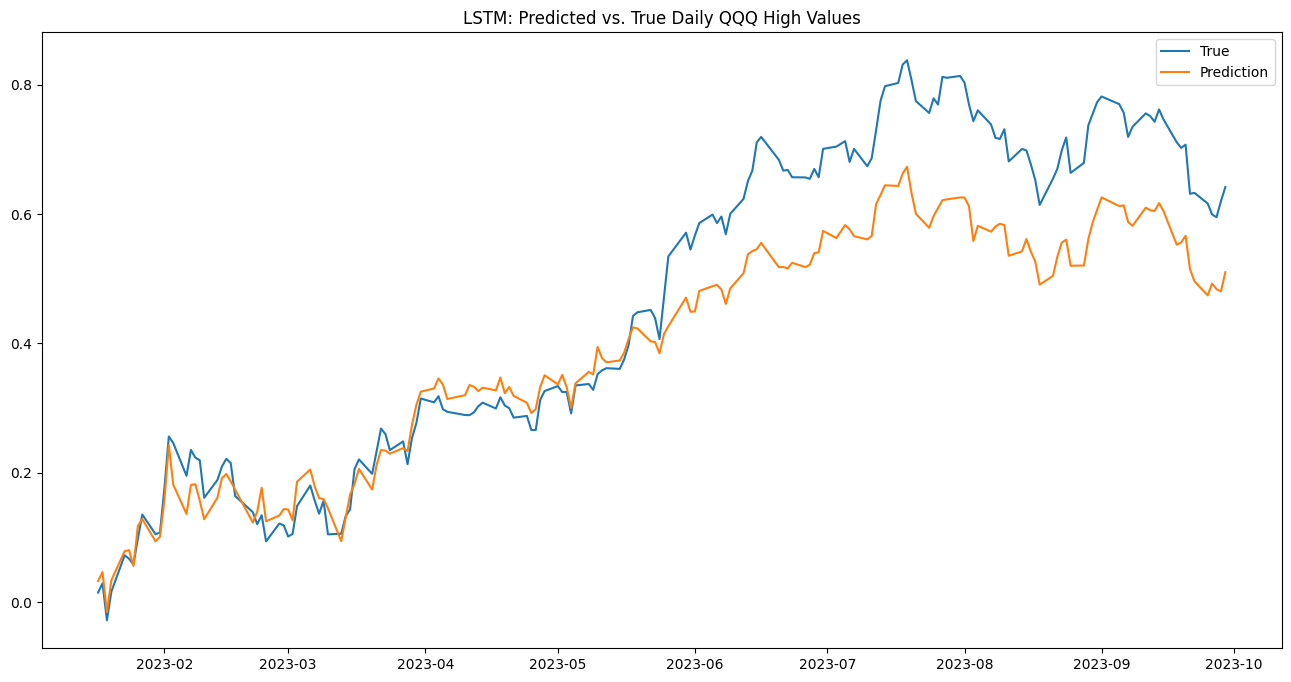

In [195]:
# predict the test set
test_preds = []
for seq, _ in test_set:
    best_model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                    torch.zeros(1, 1, model.hidden_size).to(device))
    with torch.no_grad():
        test_pred = model(seq)
        test_preds.append(test_pred.item())

y_test_array = y_test

# inverse the scaling
#test_preds = y_scaler.inverse_transform(np.array(test_preds).reshape(-1, 1))
#y_test = y_scaler.inverse_transform(y_test)
#test_preds = 60*[0] + list(test_preds.reshape(-1))
# plot the results
cut_off = len(test_preds) - 1

test_preds.pop(0) #need sizes to be even

x_axis = list(df.index)[-cut_off:] #last 179 days
plt.figure(figsize=(16, 8))
plt.plot(x_axis, list(y_test)[60:], label='True')
plt.plot(x_axis, test_preds, label='Prediction')
plt.title('LSTM: Predicted vs. True Daily QQQ High Values')
plt.legend()
plt.show()

In [ ]:
test_preds

In [ ]:
# Save the whole best model
torch.save(best_model, 'best_model_2lstm_2_high.pt')

# Prediction with ARIMA